<h1>探索性数据分析(Exploratory Data Analysis, EDA)</h1>
对自己的数据集做一个EDA分析，看看数据的分布
<ul>
    <li><a href="#bar1">1.训练集和测试集的数量</a></li>
    <li><a href="#bar2">2.每张图像的bbox的面积</a></li>
    <li><a href="#bar3">3.box的面积</a></li>
    <li><a href="#bar4">4.每张图像的bbox的面积</a></li>
    <li><a href="#bar5">5.图像的亮度</a></li>
    <li><a href="#bar6">6.最后</a></li>
</ul>

<h1><a id="bar1"> 1. 训练集和测试集的数量 </a></h1>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
# @Time    : 2022/3/7 09:04
# @Author  : chenchao
"""
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import albumentations as albu

In [2]:
# Setup the paths to train and test images
TRAIN_DIR = '/shared/xjd/DataSets/transmission_line_detection/train/'
TEST_DIR = '/shared/xjd/DataSets/transmission_line_detection/test/'
TRAIN_CSV_PATH = '/shared/xjd/DataSets/transmission_line_detection/coco2tianchi_train.json'

# Glob the directories and get the lists of train and test images
train_fns = glob(TRAIN_DIR + '*')
test_fns = glob(TEST_DIR + '*')
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 13172
Number of test images is 3290


<h1><a id="bar2">2. 每张图BBOX的数量</a><h1>

#### 读取json文件转换成dataframe


In [3]:
import json
train = []
with open(TRAIN_CSV_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)
train = pd.DataFrame(data)

train.head(5)

,name,image_height,image_width,category,bbox
0,TaDiao04804.jpg,2448,3264,3,"[470, 213, 985, 328]"
1,TaDiao04804.jpg,2448,3264,3,"[334, 302, 685, 359]"
2,TaDiao01459.jpg,900,1200,3,"[1, 122, 125, 171]"
3,SGJX04716.jpg,900,1200,2,"[744, 760, 905, 830]"
4,TaDiao04154.jpg,1944,2592,3,"[1075, 532, 1264, 599]"


#### 按照name进行合并，观察bbox

In [4]:
all_train_images = pd.DataFrame([fns.split('/')[-1] for fns in train_fns])
all_train_images.columns=['name']
# merge image with json info
all_train_images = all_train_images.merge(train, on='name', how='left')
# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')
all_train_images.head(5)

,name,image_height,image_width,category,bbox
0,DiaoChe05126.jpg,900,1200,1,"[446, 453, 613, 787]"
1,DiaoChe05126.jpg,900,1200,1,"[734, 526, 783, 606]"
2,SGJX02837.jpg,900,1200,2,"[132, 755, 283, 834]"
3,YanHuo00360.jpg,1944,2592,4,"[222, 1175, 826, 1526]"
4,DXYW00067.jpg,1944,2592,0,"[1439, 690, 1518, 835]"


#### 拆分bbox坐标方便后续观察

In [5]:
# [xmin，ymin，xmax，ymax]
bbox_items = all_train_images.bbox
all_train_images['bbox_xmin'] = bbox_items.apply(lambda x: x[0])
all_train_images['bbox_ymin'] = bbox_items.apply(lambda x: x[1])
all_train_images['bbox_width'] = bbox_items.apply(lambda x: x[2]-x[0])
all_train_images['bbox_height'] = bbox_items.apply(lambda x: x[3]-x[1])
# print(all_train_images)
print('{} images without bbox.'.format(len(all_train_images) - len(train)))

0 images without bbox.


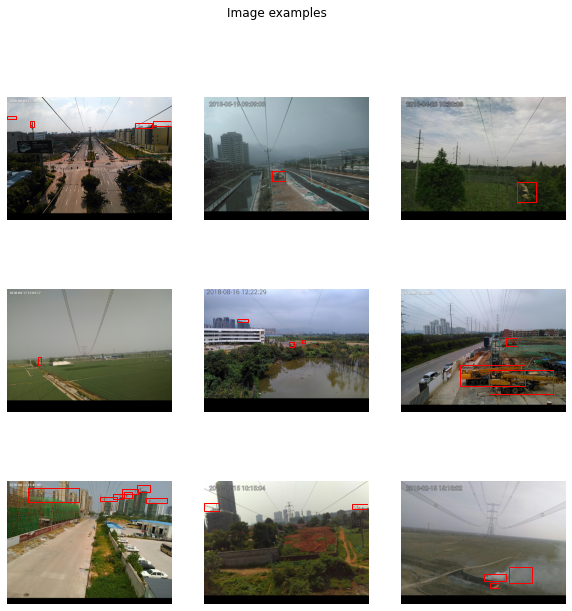

In [6]:
def get_all_bboxes(df, name):
    image_bboxes = df[df.name == name]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            name = df.iloc[idx]["name"]
            img = Image.open(TRAIN_DIR + str(name))
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, name)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)
    
plot_image_examples(all_train_images)

In [7]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [8]:
# compute the number of bounding boxes per train image
# print(all_train_images.iloc[0])
all_train_images['count'] = all_train_images.apply(lambda row: 1 if any(row.bbox) else 0, axis=1)
train_images_count = all_train_images.groupby('name').sum().reset_index()
# print(train_images_count)
hist_hover(train_images_count, 'count', title='每张图中的目标数量')

Loading BokehJS ...

#### 从图中可以看出，每张图的bbox的数量大部分集中在1-5个

#### 看一下bbox数量10以下的图示,不兼容中文，使用英文title


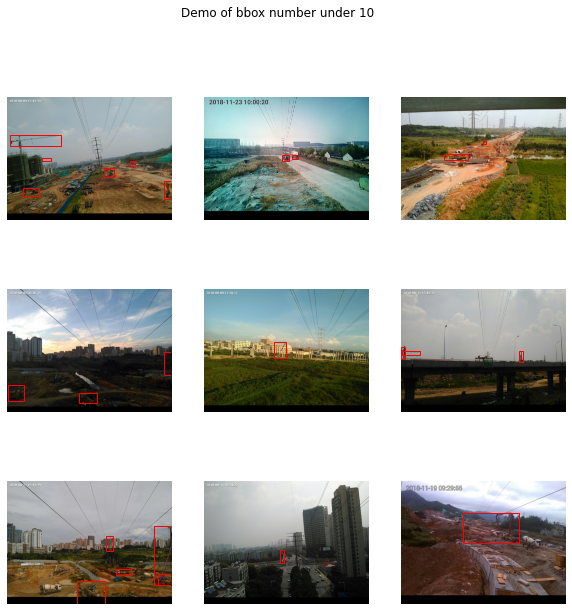

In [9]:
less_spikes_ids = train_images_count[train_images_count['count'] < 10].name
plot_image_examples(all_train_images[all_train_images.name.isin(less_spikes_ids)], title='Demo of bbox number under 10')

#### 看一下bbox数量大于10的图示,不兼容中文，使用英文title

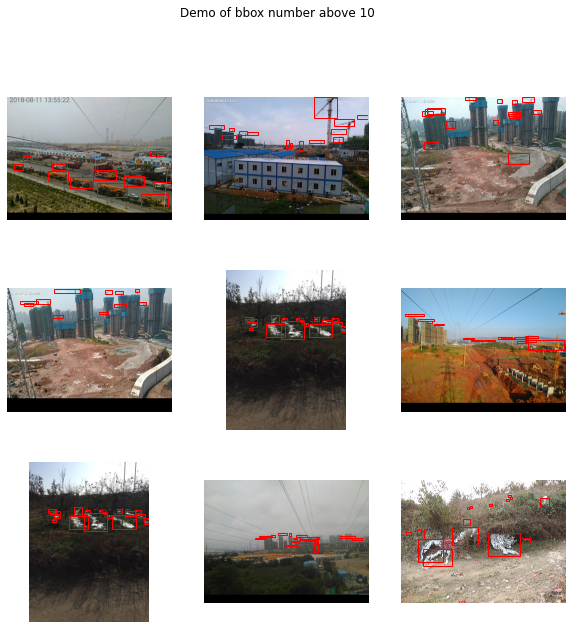

In [10]:
less_spikes_ids = train_images_count[train_images_count['count'] > 10].name
plot_image_examples(all_train_images[all_train_images.name.isin(less_spikes_ids)], title='Demo of bbox number above 10')

<h1><a id="bar3">3. bbox的面积</a></h1>

In [11]:
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

hist_hover(all_train_images, 'bbox_area', title='Area of a single bounding box')

Loading BokehJS ...

#### 最大的bbox的面积是

In [12]:
all_train_images.bbox_area.max()

7268732

#### 包围盒的面积呈现长尾分布，所以未来可以考虑去掉面积最大的进行训练，效果应该会很不错


#### 那么来看看这些超大包围盒长什么样


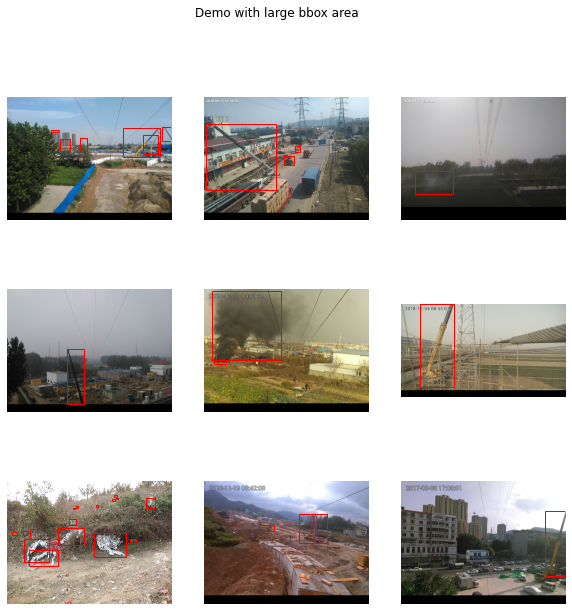

In [13]:
large_boxes_names = all_train_images[all_train_images['bbox_area'] > 200000].name
plot_image_examples(all_train_images[all_train_images.name.isin(large_boxes_names)], title='Demo with large bbox area')

#### 看来并不能去掉，这种超大的bbox是那种缺角的情况

#### 类似的我们来看看小框的情况

In [14]:
min_area = all_train_images[all_train_images['bbox_area'] > 0].bbox_area.min()
print('最小的包围框面积是： {}'.format(min_area))

最小的包围框面积是： 203


ValueError: high <= 0

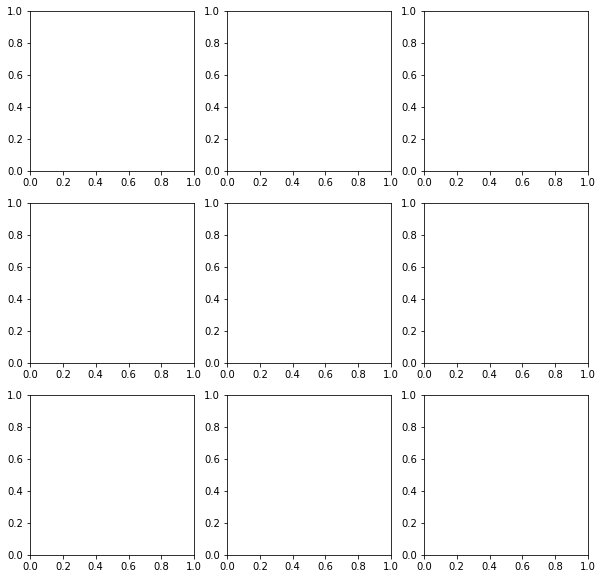

In [15]:
small_boxes_names = all_train_images[(all_train_images['bbox_area'] < 50) & (all_train_images['bbox_area'] > 0)].name
plot_image_examples(all_train_images[all_train_images.name.isin(small_boxes_names)], title='Demo with small bbox area')

#### 有点一言难尽啊，图像尺寸很大6000*8192不等，每个检测目标都很小，这就是比赛重点把

<h1><a id="bar4">4. 每张图像的bbox的面积</a></h1>

In [17]:
area_per_image = all_train_images.groupby(by='name').sum().reset_index()

# 计算bbox的面积占整体面积的百分比
area_per_image_percentage = area_per_image.copy()
# print(area_per_image_percentage)
# print(area_per_image_percentage)

def get_area(x):
#     print(x)
    ret = x['bbox_area'] / (x['image_height']*x['image_width']) * 100
    return ret

area_per_image_percentage['bbox_area'] = area_per_image_percentage.apply(get_area, axis=1)
print(area_per_image_percentage['bbox_area'])
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

0        2.711589
1        1.181654
2        5.035677
3        0.234816
4        0.334952
           ...   
13167    1.735397
13168    0.801225
13169    2.752058
13170    1.974167
13171    0.462963
Name: bbox_area, Length: 13172, dtype: float64


Loading BokehJS ...

#### 其实从上一章节也能猜到这个分布，因为大部分包围框非常小，所以占比也非常小，包围框占比也呈现一个长尾的分布

#### 来看一下这些小面积包围盒

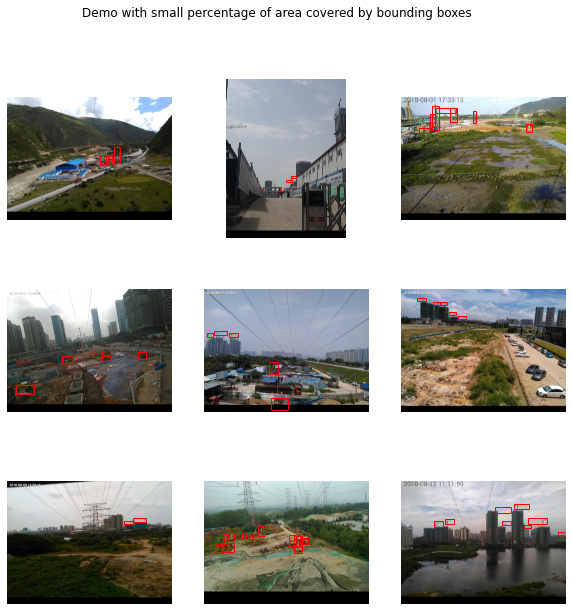

In [18]:
small_area_perc_names = area_per_image_percentage[area_per_image_percentage['bbox_area'] < 0.1].name

plot_image_examples(all_train_images[all_train_images.name.isin(small_area_perc_names)], title='Demo with small percentage of area covered by bounding boxes')

#### 同样的看看大面积包围盒

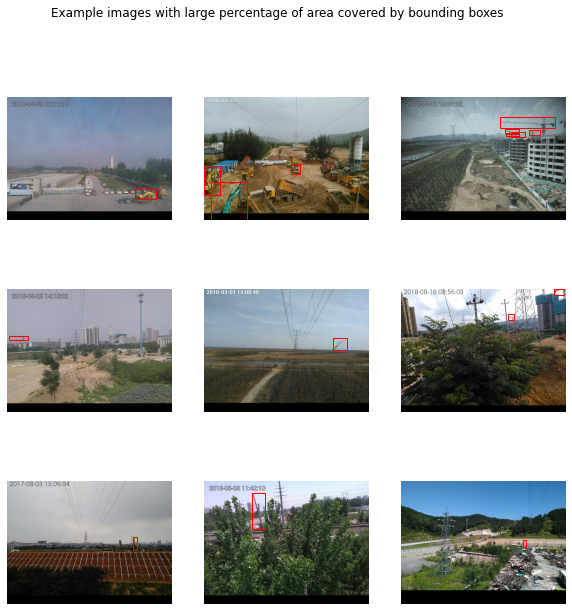

In [19]:
large_area_perc_names = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 0.1].name
plot_image_examples(all_train_images[all_train_images.name.isin(large_area_perc_names)], title='Example images with large percentage of area covered by bounding boxes')

<h1><a id="bar5">5. 图像的亮度</a></h1>

In [20]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():    
        name = row["name"]
        image = cv2.imread(TRAIN_DIR + name)
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

images_df = pd.DataFrame(all_train_images.name.unique())
images_df.columns = ['name']
brightness_df = add_brightness(images_df)

Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: bad Huffman code


In [ ]:
# print(brightness_df)
brightness_df.columns = ['name', 'brightness']
all_train_images = all_train_images.merge(brightness_df, on='name')

hist_hover(all_train_images, 'brightness', title='Images brightness distribution')

#### 这个东西有点奇怪了，只是好奇看了看亮度有没有问题，居然真有特别暗和特别亮的图像

#### 那就看看暗到什么程度

In [21]:
# print(all_train_images)
dark_names = all_train_images[all_train_images['brightness'] < 50].name
plot_image_examples(all_train_images[all_train_images.name.isin(dark_names)], title='Darkest images')

KeyError: 'brightness'

#### 看看锃亮到什么程度

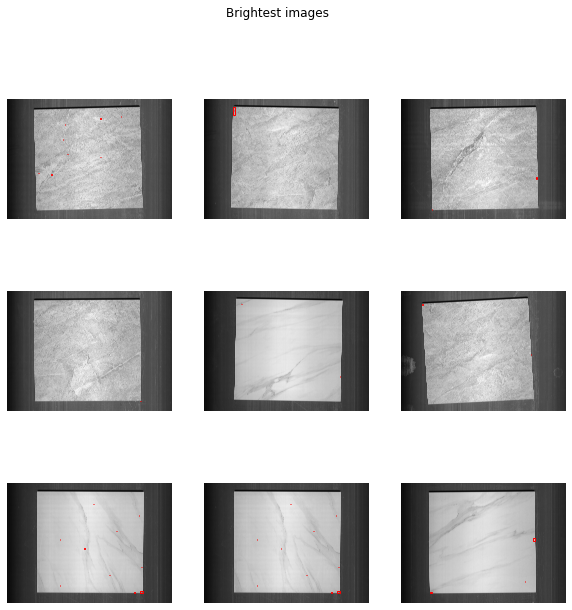

In [30]:
bright_names = all_train_images[all_train_images['brightness'] > 130].name
plot_image_examples(all_train_images[all_train_images.name.isin(bright_names)], title='Brightest images')

<h1><a id="bar6">6. 最后</a></h1>

#### 一点小小的看法，图很大，框很小，肯定要考虑裁剪成小图像来进行训练，直接训练效果肯定不好，参考卫星图像识别的做法，YOLT这样的拆一拆
#### 数据增强方面
- flipping 
- crop-resize
- 适当调节明暗度？？？
- 或许还可以考虑最新的grid-mask？？？

# 顺带一提，有没有大佬带我？2080ti两张，github，google贼溜那种